In [ ]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
import matplotlib.pyplot as plt
import os
import random

seed=42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Normalisation des images pour les modèles pré-entraînés PyTorch

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
image_directory = "/content/gdrive/MyDrive/ProjetFromage/data_fromage"
dataset_full = datasets.ImageFolder(image_directory, data_transforms)

# split en train, val et test à partir de la liste complète
np.random.seed(42)
samples_train, samples_test = train_test_split(dataset_full.samples)
samples_train, samples_val = train_test_split(samples_train,test_size=0.2)

print("Nombre d'images de train : %i" % len(samples_train))
print("Nombre d'images de val : %i" % len(samples_val))
print("Nombre d'images de test : %i" % len(samples_test))

Nombre d'images de train : 2288
Nombre d'images de val : 572
Nombre d'images de test : 954


In [ ]:
# on définit les datasets et loaders pytorch à partir des listes d'images de train / val / test
dataset_train = datasets.ImageFolder(image_directory, data_transforms)
dataset_train.samples = samples_train
dataset_train.imgs = samples_train
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)

dataset_val = datasets.ImageFolder(image_directory, data_transforms)
dataset_val.samples = samples_val
dataset_val.imgs = samples_val

dataset_test = datasets.ImageFolder(image_directory, data_transforms)
dataset_test.samples = samples_test
dataset_test.imgs = samples_test

torch.manual_seed(42)

In [ ]:
# détermination du nombre de classes
# vérification que les labels sont bien dans [0, nb_classes]
labels=[x[1] for x in samples_train]
if np.min(labels) != 0:
    print("Error: labels should start at 0 (min is %i)" % np.min(labels))
    sys.exit(-1)
if np.max(labels) != (len(np.unique(labels))-1):
    print("Error: labels should go from 0 to Nclasses (max label = {}; Nclasse = {})".format(np.max(labels),len(np.unique(labels)))  )
    sys.exit(-1)
nb_classes = np.max(labels)+1
print("Apprentissage sur {} classes".format(nb_classes))

Apprentissage sur 43 classes


In [ ]:
# on définit le modèle CNN

NUM_CONV_1=32 
NUM_CONV_2=64 
NUM_FC=1024 
NUM_CLASSES=nb_classes
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv_1 = nn.Conv2d(3,NUM_CONV_1,6,1) # kernel_size = 6
        self.conv_2 = nn.Conv2d(NUM_CONV_1,NUM_CONV_2,5,1) # kernel_size = 5
        self.fc_1 = nn.Linear(52*52*NUM_CONV_2, NUM_FC)
        self.fc_2 = nn.Linear(NUM_FC,NUM_CLASSES)
    def forward(self,x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,52*52*NUM_CONV_2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


In [ ]:
# on définit le device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [ ]:
# on définit une fonction d'évaluation
def evaluate(model, dataset):
    avg_loss = 0.
    avg_accuracy = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)
    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        n_correct = torch.sum(preds == labels)
        
        avg_loss += loss.item()
        avg_accuracy += n_correct
        
    return avg_loss / len(dataset), float(avg_accuracy) / len(dataset)

# fonction d'entraînement du modèle
PRINT_LOSS = False

def train_model(model, loader_train, data_val, optimizer, criterion, n_epochs=10, scheduler=None, scheduler_name="No Scheduler"):
    lrs=[]
    since = time.time()
    best_acc=0
    best_model_wts = copy.deepcopy(model.state_dict())
    saved_acc=[]

    for epoch in range(n_epochs): 
        batch=0
        print("EPOCH % i" % epoch)
        for i, data in enumerate(loader_train):
            batch+=1
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            optimizer.zero_grad() 
            outputs = model(inputs) 
            
            loss = criterion(outputs, labels) 
            if PRINT_LOSS:
                model.train(False)
                loss_val, accuracy = evaluate(model, data_val)
                model.train(True)
                print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))
            
            loss.backward() 
            optimizer.step() 
            lrs.append(optimizer.param_groups[0]["lr"])
            if scheduler:
              scheduler.step()

        model.train(False)
        loss_val, accuracy = evaluate(model, data_val)
        saved_acc.append(accuracy)
        #early stopping
        if accuracy>best_acc:
          best_acc=accuracy
          best_model_wts = copy.deepcopy(model.state_dict())
        model.train(True)
        print("{} loss train: {:1.4f}\t val {:1.4f}\tAcc (val): {:.1%}".format(i, loss.item(), loss_val, accuracy   ))

    plt.plot(lrs, label=scheduler_name)
    model.load_state_dict(best_model_wts)
    return best_acc



Apprentissage : Weight Decay = 0 ; Scheduler = No Scheduler
EPOCH  0
71 loss train: 3.5183	 val 0.2236	Acc (val): 7.3%
EPOCH  1
71 loss train: 3.6621	 val 0.2097	Acc (val): 12.8%
EPOCH  2
71 loss train: 2.6439	 val 0.2069	Acc (val): 13.3%
EPOCH  3
71 loss train: 2.4089	 val 0.1892	Acc (val): 26.0%
EPOCH  4
71 loss train: 2.4548	 val 0.1910	Acc (val): 26.9%
EPOCH  5
71 loss train: 0.9550	 val 0.1924	Acc (val): 37.4%
EPOCH  6
71 loss train: 0.5032	 val 0.2036	Acc (val): 39.2%
EPOCH  7
71 loss train: 0.0418	 val 0.2455	Acc (val): 38.5%
EPOCH  8
71 loss train: 0.0876	 val 0.2273	Acc (val): 43.4%
EPOCH  9
71 loss train: 0.0102	 val 0.2354	Acc (val): 42.7%
Best Acc Val = 0.43356643356643354

Apprentissage : Weight Decay = 0 ; Scheduler = Multiplicative Scheduler
EPOCH  0
71 loss train: 3.5081	 val 0.2191	Acc (val): 7.7%
EPOCH  1
71 loss train: 3.6716	 val 0.2056	Acc (val): 14.0%
EPOCH  2
71 loss train: 2.4905	 val 0.2034	Acc (val): 15.7%
EPOCH  3
71 loss train: 2.2252	 val 0.1836	Acc (val): 

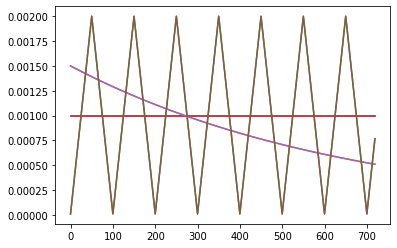

In [ ]:
#===== Apprentissage

global_best_acc=0
best_param={}
best_net=CNNNet()

for weight_decay in [0, 0.0001]:
  for scheduler_name in ["No Scheduler","Multiplicative Scheduler", "Cyclic Scheduler"]:

    my_net = CNNNet()
    my_net.to(device) 
    my_net.train(True) 

    criterion = nn.CrossEntropyLoss()
    optimizer0 = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
    optimizer1 = optim.SGD(my_net.parameters(), lr=0.001, momentum=0.9, weight_decay=weight_decay)
    optimizer2 = optim.SGD(my_net.parameters(), lr=0.0015, momentum=0.9, weight_decay=weight_decay)

    dic_scheduler={"No Scheduler":[None, optimizer0]}
    scheduler1=optim.lr_scheduler.CyclicLR(optimizer1, base_lr=0.00001, max_lr=0.002,step_size_up=50,mode="triangular")
    dic_scheduler["Cyclic Scheduler"]=[scheduler1, optimizer1]
    lambda2 = lambda x: 0.9985 ** x
    scheduler2 = optim.lr_scheduler.LambdaLR(optimizer2, lr_lambda=lambda2)
    dic_scheduler["Multiplicative Scheduler"]=[scheduler2, optimizer2]

    scheduler=dic_scheduler[scheduler_name][0]
    optimizer=dic_scheduler[scheduler_name][1]

    print(f'Apprentissage : Weight Decay = {weight_decay} ; Scheduler = {scheduler_name}')
    my_net.train(True)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    best_acc=train_model(my_net, loader_train, dataset_val, optimizer, criterion, n_epochs=10, scheduler=scheduler, scheduler_name=scheduler_name)
    print(f'Best Acc Val = {best_acc}\n')
    if best_acc>global_best_acc:
      global_best_acc=best_acc
      best_param={"Weight decay":weight_decay, "Scheduler":scheduler_name}
      best_net=my_net

print(">>> Best param :")
for key, item in best_param.items():
  print(f'{key} = {item}')

# évaluation
best_net.train(False)
loss, accuracy = evaluate(best_net, dataset_test)
print("Accuracy (test): %.1f%%" % (100 * accuracy))

In [ ]:
torch.cuda.empty_cache()